In [2]:
from PIL import Image
from  torchvision import transforms
import torch
import open_clip
from sys import path
path.append("../")
from src.models.biomedclipseg import BiomedCLIPSeg

In [3]:
class_names = [
    "polyp",
    "breast ultrasoud"
    "ultrasound",
    "echocardiograhpy",
    "skin_cancer",
    "cardiomegaly",
    "pneumonia",
    "hypertension",
    "lung_nodule",
    "diabetic foot ulcer"
]

def get_prompt(class_name:str) -> str:
    return f"This is a picture of {class_name}"

In [14]:
biomedclip_hf_api = "hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224" 
tokenizer = open_clip.get_tokenizer(biomedclip_hf_api)

img_mean = [0.48145466, 0.4578275, 0.40821073]
img_std = [0.26862954, 0.26130258, 0.27577711]

img_preprocessor = transforms.Compose([
    transforms.Resize((416,416)),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std)
])

img_path = "/home/manish/sedoc/medvlsm/data/dfu/images/100001.jpg"
pil_img = Image.open(img_path).convert("RGB")
img_tensor = img_preprocessor(pil_img)[None,]

prompts = [ get_prompt(c) for c in class_names]
text_ids =  tokenizer(prompts, context_length=25)


In [15]:
biomedclipseg = BiomedCLIPSeg()
image_embeddings, image_hidden_states = biomedclipseg._forward_vit(img_tensor, output_hidden_states=True)
text_embeddings, text_hidden_states = biomedclipseg._forward_bert(text_ids)

2023-11-07 17:10:34,544 - Loaded hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224 model config.


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2023-11-07 17:10:38,350 - Loading pretrained hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224 weights (None).


AssertionError: Input image height (416) doesn't match model (224).

In [ ]:
sim_scores = torch.cosine_similarity(text_embeddings, image_embeddings)
for c, sim_score in zip(class_names, sim_scores):
    print(f"The similaity score between {c} and image: {sim_score}")

The similaity score between polyp and image: 0.11029593646526337
The similaity score between breast ultrasoudultrasound and image: 0.11515961587429047
The similaity score between echocardiograhpy and image: 0.07521528005599976
The similaity score between skin_cancer and image: 0.2832188308238983
The similaity score between cardiomegaly and image: 0.17858745157718658
The similaity score between pneumonia and image: 0.22349613904953003
The similaity score between hypertension and image: 0.2616083323955536
The similaity score between lung_nodule and image: 0.07062393426895142
The similaity score between diabetic foot ulcer and image: 0.35241571068763733


In [12]:
pixels_embeddings = image_hidden_states[-1]
pixels_embeddings = torch.norm(pixels_embeddings, dim=-1)
numpy_embeddings = pixels_embeddings[0][1:].reshape(14,14).numpy()

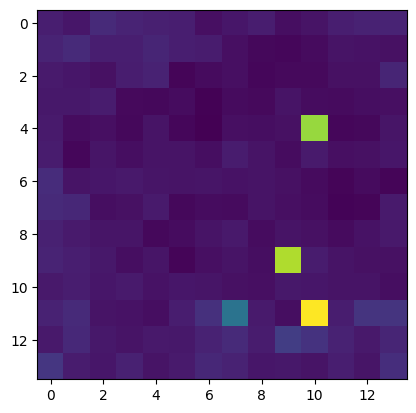

In [13]:
from matplotlib import pyplot as plt
plt.imshow(numpy_embeddings)